In [1]:
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
tf.config.list_physical_devices()

Versions of key libraries
---
tensorflow:  2.9.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
modelname   = 'luohan'

fishType = modelname
IMGSIZE = 128
EPOCHS = 50
BATCH_SIZE = 64
OPT_IDX = 1
ACTIVATION = 'softmax'
N_LABELS = 2

modelname = modelname+"_"+ACTIVATION+"_"+str(IMGSIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001)]
optmz = optmzs[OPT_IDX]

In [4]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMGSIZE,IMGSIZE,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(N_LABELS, activation=ACTIVATION))
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0

In [5]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/luohan_softmax_128_50_64_1_2022-09-25_22-42-17.hdf5
Path to log:   models/luohan_softmax_128_50_64_1_2022-09-25_22-42-17.csv


In [6]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/luohan_softmax_128_50_64_1_2022-09-25_22-42-17_plot.png


In [7]:
data_dir = pathlib.Path("dataset")
fish_images_dict = {
    'arowana': list(data_dir.glob('arowana/*.jpg')),
    'betta': list(data_dir.glob('betta/*.jpg')),
    'goldfish': list(data_dir.glob('goldfish/*.jpg')),
    'luohan': list(data_dir.glob('luohan/*.jpg'))
}
# labelname = ['arowana','betta','goldfish','luohan']
labelname = ['not '+fishType, fishType]

In [8]:
def process_image(img_file, h=IMGSIZE, w=IMGSIZE):
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.preprocessing.image.smart_resize(
        img_array, size=(h, w))
#     img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = img_array / 255.0
    return img_array


In [9]:
X, y = [], []

for fish_name, images in fish_images_dict.items():
    for image in images:
        X.append(process_image(image))
        y.append(1 if fish_name==fishType else 0)

C:\Users\song\anaconda3\envs\tfgpu\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
X = np.array(X)
oy = np.array(y)
y = to_categorical(oy)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
history = model.fit(X_train,                            # Training data
          y_train,                            # Training label
          validation_data=(X_test, y_test),   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIZE,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/50
39/39 [==============================] - 8s 38ms/step - loss: 0.5869 - accuracy: 0.7198 - val_loss: 0.5481 - val_accuracy: 0.7307
Epoch 2/50
39/39 [==============================] - 1s 21ms/step - loss: 0.5118 - accuracy: 0.7645 - val_loss: 0.4984 - val_accuracy: 0.7609
Epoch 3/50
39/39 [==============================] - 1s 22ms/step - loss: 0.4611 - accuracy: 0.7886 - val_loss: 0.4587 - val_accuracy: 0.7838
Epoch 4/50
39/39 [==============================] - 1s 21ms/step - loss: 0.4243 - accuracy: 0.8120 - val_loss: 0.4385 - val_accuracy: 0.7971
Epoch 5/50
39/39 [==============================] - 1s 21ms/step - loss: 0.4014 - accuracy: 0.8140 - val_loss: 0.4101 - val_accuracy: 0.8056
Epoch 6/50
39/39 [==============================] - 1s 21ms/step - loss: 0.3748 - accuracy: 0.8313 - val_loss: 0.3899 - val_accuracy: 0.8213
Epoch 7/50
39/39 [==============================] - 1s 21ms/step - loss: 0.3605 - accuracy: 0.8426 - val_loss: 0.3806 - val_accuracy: 0.8249
Epoch 8/50
39

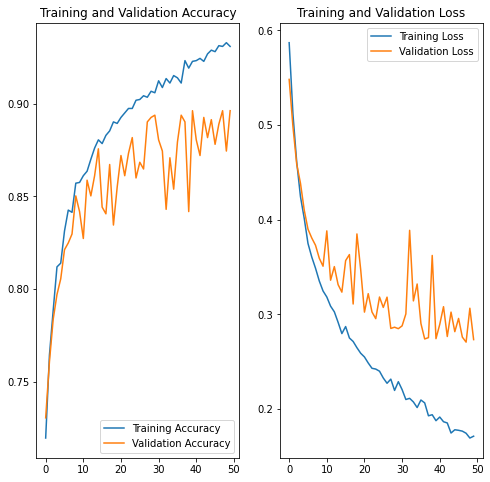

In [12]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [13]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(X_test)                                            # Step 2
print("Prediction completes.")

26/26 [==============================] - 0s 6ms/step
Prediction completes.


In [14]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 89.61%
              precision    recall  f1-score   support

  not luohan     0.9055    0.9496    0.9270       575
      luohan     0.8711    0.7747    0.8201       253

    accuracy                         0.8961       828
   macro avg     0.8883    0.8621    0.8735       828
weighted avg     0.8950    0.8961    0.8943       828

